/usr/bin/env python
coding: utf-8
# Student Dropout Prediction: Comprehensive Analysis

This notebook provides a detailed analysis of the "Dropout or Academic Success" dataset, including exploratory data analysis, feature engineering, model training, and hyperparameter tuning.
## 1. Setup and Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import xgboost as xgb
import lightgbm as lgb
import optuna
from optuna.visualization import plot_param_importances, plot_optimization_history
import joblib
import os
import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

Import necessary libraries
Set random seed for reproducibility
Set up plotting

Load the dataset
Display basic information
## 2. Exploratory Data Analysis (EDA)
### 2.1 Data Overview

In [2]:
print("Loading dataset...")
data_path = '../data/dataset.csv'  # Update this path if needed
df = pd.read_csv(data_path)

print(f"Dataset shape: {df.shape}")
print("\nFirst 5 rows:")
df.head()

Loading dataset...
Dataset shape: (4424, 37)

First 5 rows:


,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


Display data types

In [3]:
print("Data types:")
df.dtypes

Data types:


Marital status                                      int64
Application mode                                    int64
Application order                                   int64
Course                                              int64
Daytime/evening attendance                          int64
Previous qualification                              int64
Previous qualification (grade)                    float64
Nacionality                                         int64
Mother's qualification                              int64
Father's qualification                              int64
Mother's occupation                                 int64
Father's occupation                                 int64
Admission grade                                   float64
Displaced                                           int64
Educational special needs                           int64
Debtor                                              int64
Tuition fees up to date                             int64
Gender        

Basic statistics for numerical columns

In [4]:
print("Basic statistics for numerical columns:")
df.describe()

Basic statistics for numerical columns:


,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP
count,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,...,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000
mean,1.178571,18.669078,1.727848,8856.642631,0.890823,4.577758,132.613314,1.873192,19.561935,22.275316,...,0.137658,0.541817,6.232143,8.063291,4.435805,10.230206,0.150316,11.566139,1.228029,0.001969
std,0.605747,17.484682,1.313793,2063.566416,0.311897,10.216592,13.188332,6.914514,15.603186,15.343108,...,0.690880,1.918546,2.195951,3.947951,3.014764,5.210808,0.753774,2.663850,1.382711,2.269935
min,1.000000,1.000000,0.000000,33.000000,0.000000,1.000000,95.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.600000,-0.800000,-4.060000
25%,1.000000,1.000000,1.000000,9085.000000,1.000000,1.000000,125.000000,1.000000,2.000000,3.000000,...,0.000000,0.000000,5.000000,6.000000,2.000000,10.750000,0.000000,9.400000,0.300000,-1.700000
50%,1.000000,17.000000,1.000000,9238.000000,1.000000,1.000000,133.100000,1.000000,19.000000,19.000000,...,0.000000,0.000000,6.000000,8.000000,5.000000,12.200000,0.000000,11.100000,1.400000,0.320000
75%,1.000000,39.000000,2.000000,9556.000000,1.000000,1.000000,140.000000,1.000000,37.000000,37.000000,...,0.000000,0.000000,7.000000,10.000000,6.000000,13.333333,0.000000,13.900000,2.600000,1.790000
max,6.000000,57.000000,9.000000,9991.000000,1.000000,43.000000,190.000000,109.000000,44.000000,44.000000,...,12.000000,19.000000,23.000000,33.000000,20.000000,18.571429,12.000000,16.200000,3.700000,3.510000


Basic statistics for categorical columns
### 2.2 Missing Values Analysis

In [5]:
print("Basic statistics for categorical columns:")
df.describe(include=['object', 'category'])

Basic statistics for categorical columns:


,Target
count,4424
unique,3
top,Graduate
freq,2209


Check for missing values

In [6]:
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100

missing_data = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percent
})

print("Missing values analysis:")
missing_data[missing_data['Missing Values'] > 0].sort_values('Percentage', ascending=False)

Missing values analysis:


,Missing Values,Percentage


Visualize missing values
### 2.3 Target Variable Analysis

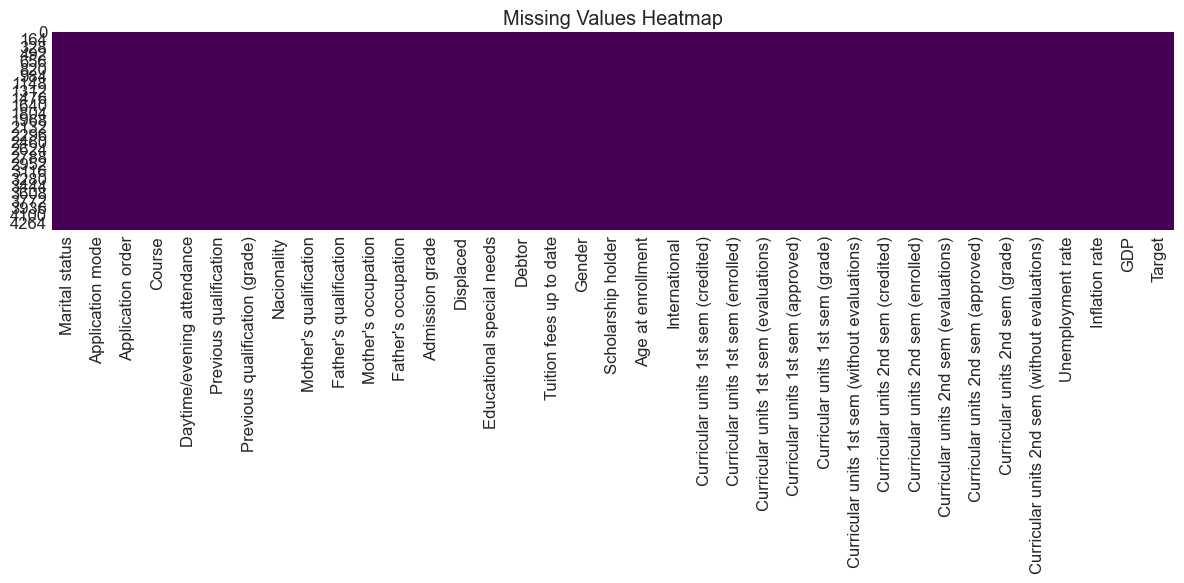

In [7]:
plt.figure(figsize=(12, 6))
plt.title('Missing Values Heatmap')
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.tight_layout()
plt.savefig('../data/missing_values_heatmap.png')
plt.show()

Analyze target variable distribution

In [8]:
target_col = 'Target'  # Update this to the actual target column name
target_counts = df[target_col].value_counts()
target_percent = target_counts / len(df) * 100

print("Target variable distribution:")
pd.DataFrame({
    'Count': target_counts,
    'Percentage': target_percent
})

Target variable distribution:


,Count,Percentage
Target,,
Graduate,2209,49.932188
Dropout,1421,32.120253
Enrolled,794,17.947559


Visualize target distribution
Add percentage labels
### 2.4 Feature Analysis

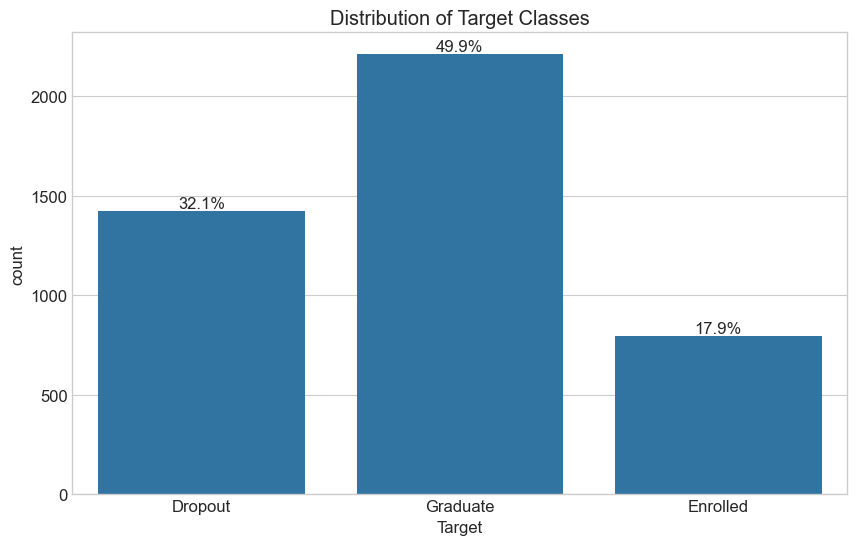

In [9]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(x=target_col, data=df)
plt.title('Distribution of Target Classes')

for p in ax.patches:
    percentage = f'{100 * p.get_height() / len(df):.1f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom')

plt.savefig('../data/target_distribution.png')
plt.show()

Analyze numerical features

In [10]:
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
if target_col in numerical_cols:
    numerical_cols.remove(target_col)

print(f"Number of numerical features: {len(numerical_cols)}")
print("Numerical features:", numerical_cols)

Number of numerical features: 36
Numerical features: ['Marital status', 'Application mode', 'Application order', 'Course', 'Daytime/evening attendance', 'Previous qualification', 'Previous qualification (grade)', 'Nacionality', "Mother's qualification", "Father's qualification", "Mother's occupation", "Father's occupation", 'Admission grade', 'Displaced', 'Educational special needs', 'Debtor', 'Tuition fees up to date', 'Gender', 'Scholarship holder', 'Age at enrollment', 'International', 'Curricular units 1st sem (credited)', 'Curricular units 1st sem (enrolled)', 'Curricular units 1st sem (evaluations)', 'Curricular units 1st sem (approved)', 'Curricular units 1st sem (grade)', 'Curricular units 1st sem (without evaluations)', 'Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (enrolled)', 'Curricular units 2nd sem (evaluations)', 'Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (grade)', 'Curricular units 2nd sem (without evaluations)', 'Unemployment ra

Analyze categorical features

In [11]:
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
if target_col in categorical_cols:
    categorical_cols.remove(target_col)

print(f"Number of categorical features: {len(categorical_cols)}")
print("Categorical features:", categorical_cols)

Number of categorical features: 0
Categorical features: []


Distribution of numerical features

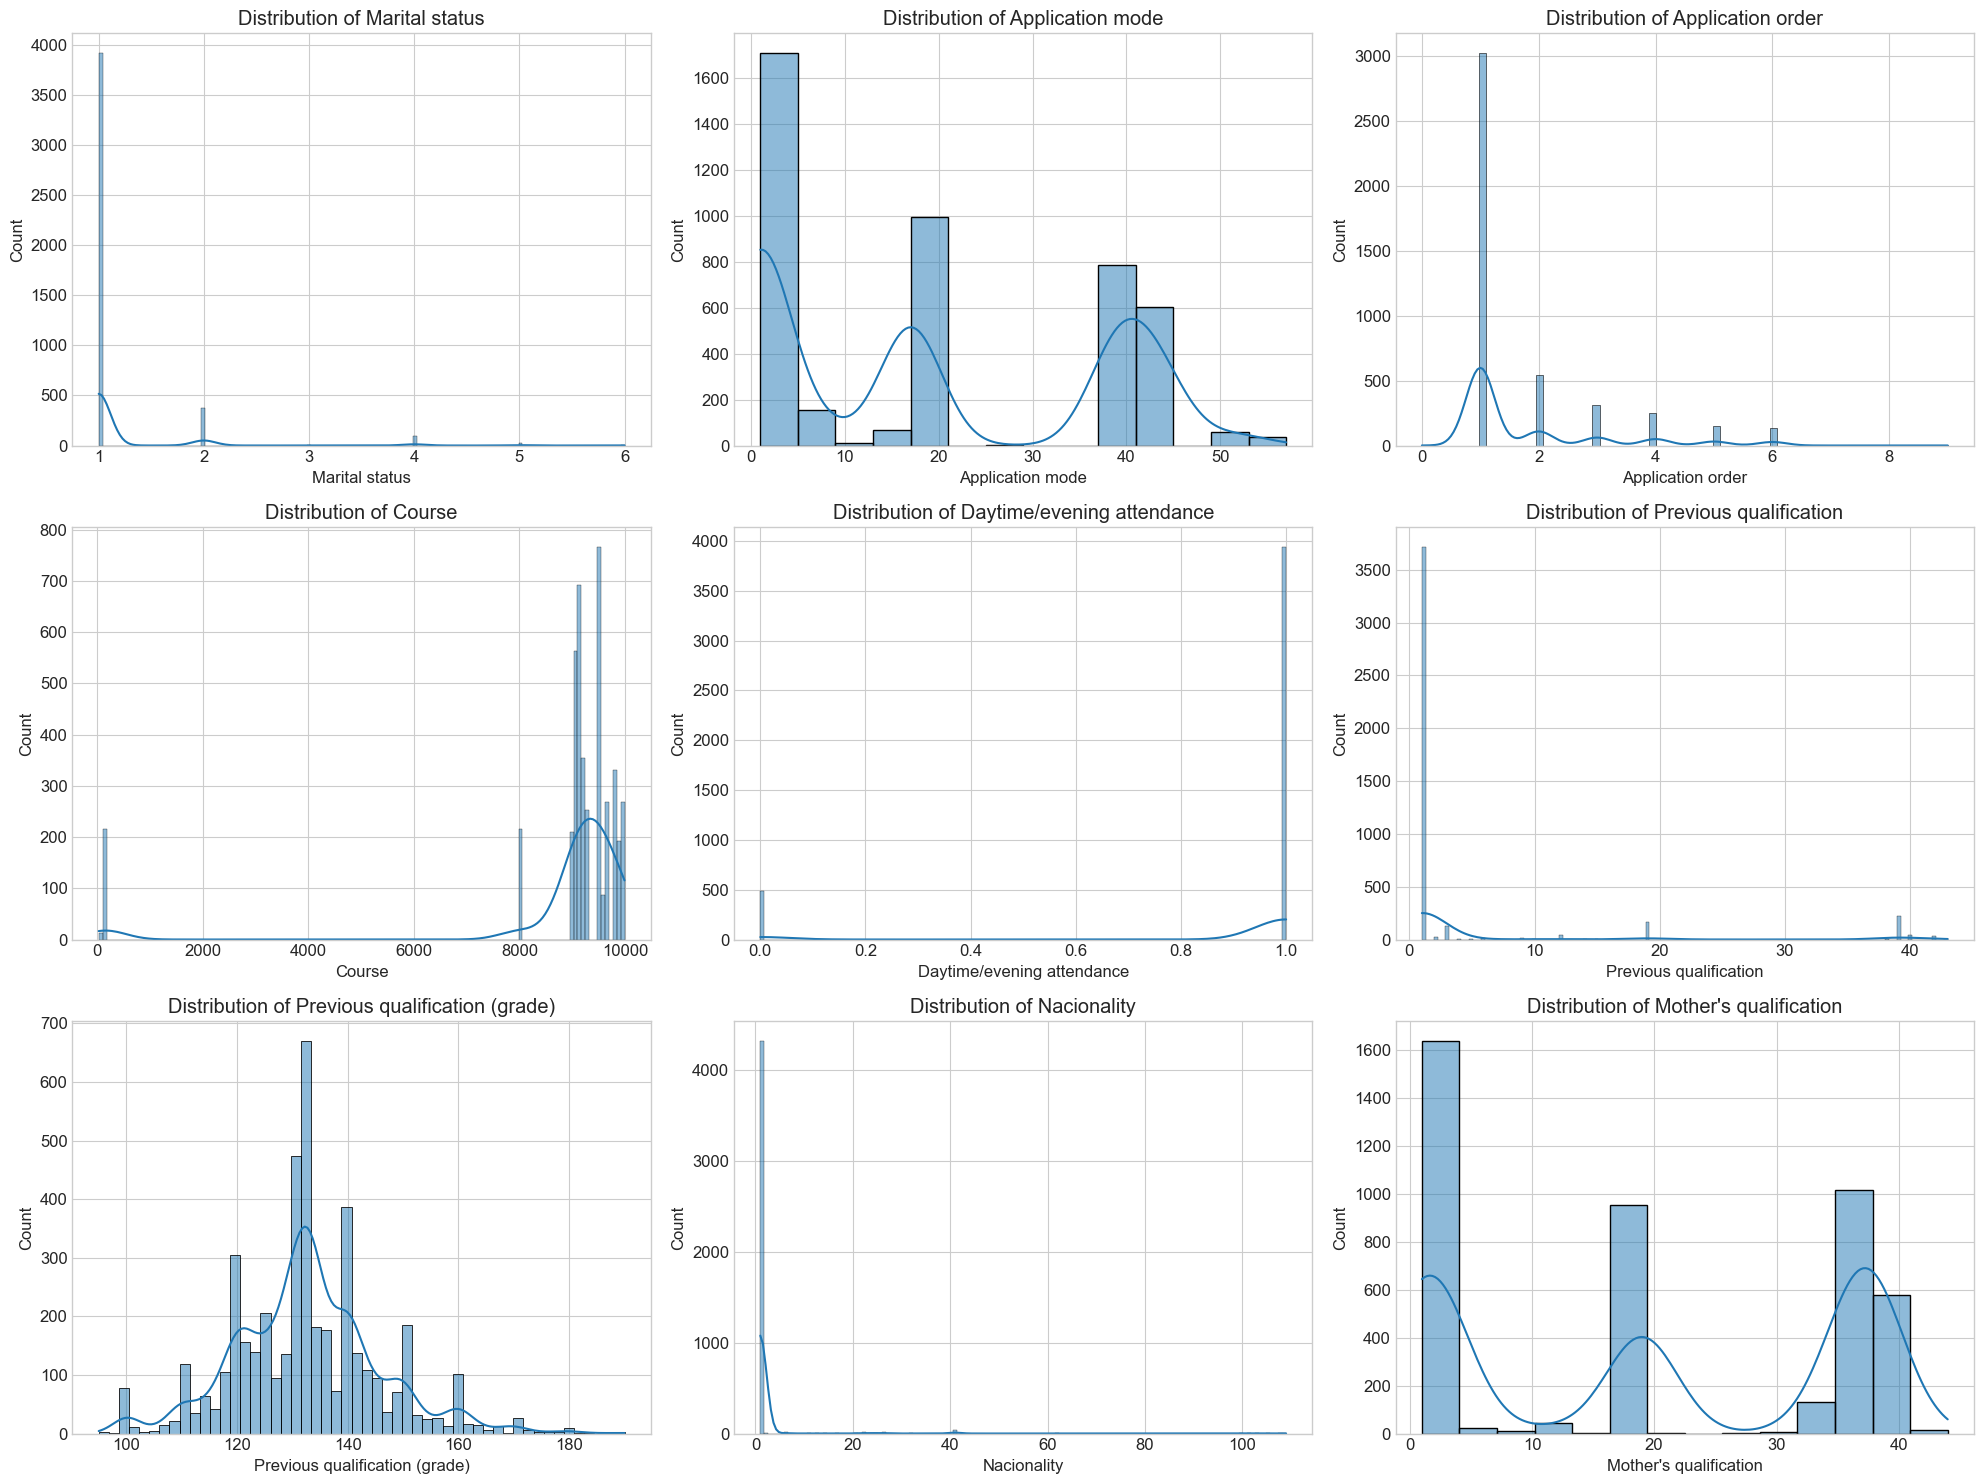

In [12]:
plt.figure(figsize=(20, 15))
for i, col in enumerate(numerical_cols[:9], 1):  # Plot first 9 numerical features
    plt.subplot(3, 3, i)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.savefig('../data/numerical_distributions.png')
plt.show()

Distribution of categorical features
### 2.5 Correlation Analysis

In [13]:
plt.figure(figsize=(20, 15))
for i, col in enumerate(categorical_cols[:9], 1):  # Plot first 9 categorical features
    plt.subplot(3, 3, i)
    value_counts = df[col].value_counts()
    sns.barplot(x=value_counts.index, y=value_counts.values)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../data/categorical_distributions.png')
plt.show()





<Figure size 2000x1500 with 0 Axes>

Correlation matrix for numerical features
Plot correlation heatmap

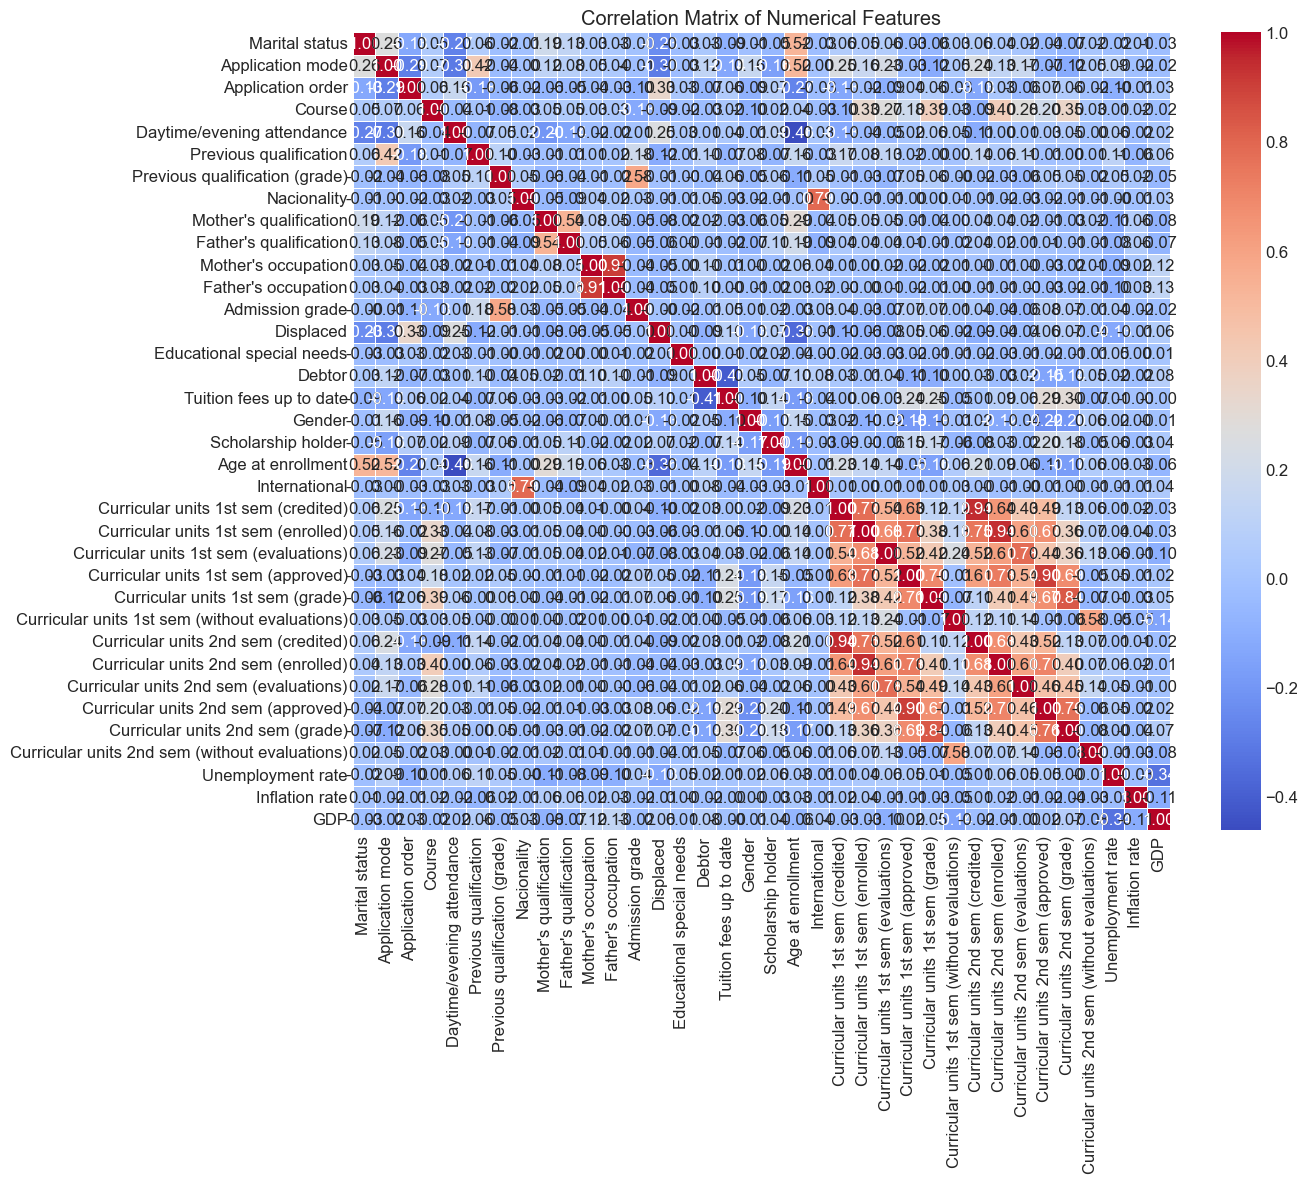

In [14]:
correlation = df[numerical_cols].corr()

plt.figure(figsize=(14, 12))
sns.heatmap(correlation, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.savefig('../data/correlation_heatmap.png')
plt.show()

Top correlated features with target (if target is numerical)
### 2.6 Feature Relationships with Target

In [15]:
if target_col in df.select_dtypes(include=['int64', 'float64']).columns:
    target_correlation = correlation[target_col].sort_values(ascending=False)
    print("Top correlations with target variable:")
    print(target_correlation)

Analyze relationship between numerical features and target

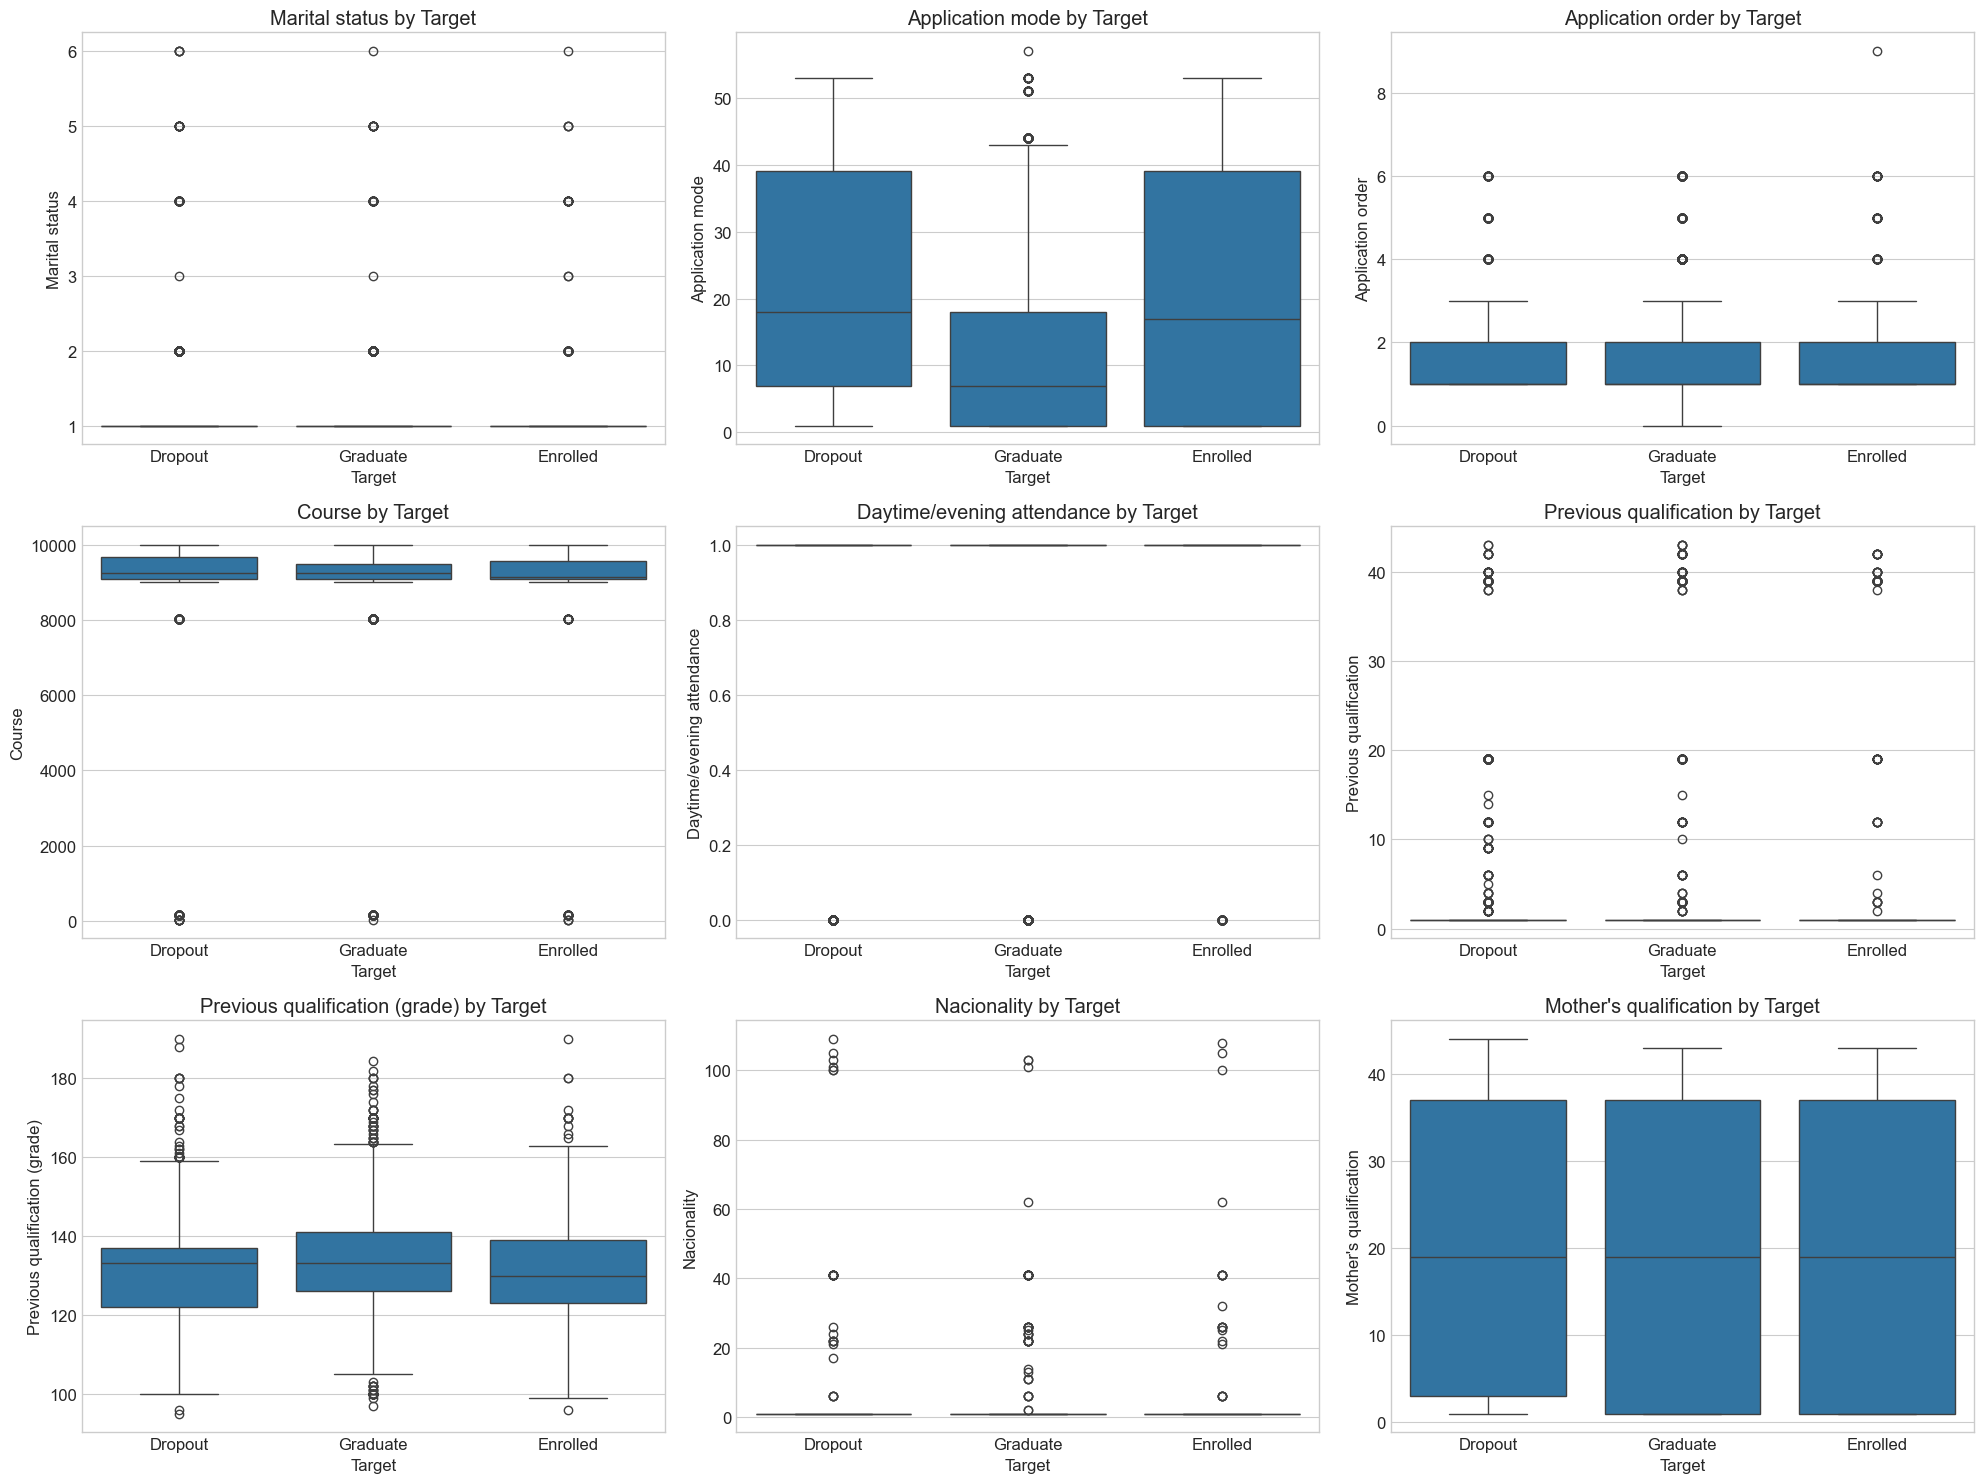

In [16]:
plt.figure(figsize=(20, 15))
for i, col in enumerate(numerical_cols[:9], 1):  # Plot first 9 numerical features
    plt.subplot(3, 3, i)
    sns.boxplot(x=target_col, y=col, data=df)
    plt.title(f'{col} by {target_col}')
plt.tight_layout()
plt.savefig('../data/numerical_vs_target.png')
plt.show()

Analyze relationship between categorical features and target
Create a crosstab
Plot
## 3. Feature Engineering
### 3.1 Handling Missing Values

In [17]:
for col in categorical_cols[:5]:  # Analyze first 5 categorical features
    plt.figure(figsize=(12, 6))
    
    ct = pd.crosstab(df[col], df[target_col])
    ct_pct = ct.div(ct.sum(axis=1), axis=0) * 100
    
    ct_pct.plot(kind='bar', stacked=True)
    plt.title(f'{col} vs {target_col}')
    plt.ylabel('Percentage')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'../data/{col}_vs_target.png')
    plt.show()

Analyze missing values patterns
Strategy for handling missing values
### 3.2 Encoding Categorical Variables

In [18]:
print("Missing values per column:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

print("\nStrategy for handling missing values:")
print("- Numerical features: Impute with median")
print("- Categorical features: Impute with most frequent value")

Missing values per column:
Series([], dtype: int64)

Strategy for handling missing values:
- Numerical features: Impute with median
- Categorical features: Impute with most frequent value


Analyze cardinality of categorical features
Strategy for encoding categorical variables
### 3.3 Feature Transformation

In [19]:
print("Cardinality of categorical features:")
for col in categorical_cols:
    print(f"{col}: {df[col].nunique()} unique values")

print("\nStrategy for encoding categorical variables:")
print("- High cardinality features: One-hot encoding")
print("- Binary features: Label encoding")

Cardinality of categorical features:

Strategy for encoding categorical variables:
- High cardinality features: One-hot encoding
- Binary features: Label encoding


Check for skewed numerical features
Identify highly skewed features (|skew| > 1)
Strategy for transforming skewed features
### 3.4 Feature Selection

In [20]:
skewness = df[numerical_cols].skew().sort_values(ascending=False)
print("Skewness of numerical features:")
print(skewness)

highly_skewed = skewness[abs(skewness) > 1].index.tolist()
print("\nHighly skewed features:")
print(highly_skewed)

print("\nStrategy for transforming skewed features:")
print("- Apply log transformation to highly skewed features")

Skewness of numerical features:
Nacionality                                       10.703998
Educational special needs                          9.154976
Curricular units 1st sem (without evaluations)     8.207403
Curricular units 2nd sem (without evaluations)     7.267701
International                                      6.104830
Father's occupation                                5.395173
Mother's occupation                                5.339227
Curricular units 2nd sem (credited)                4.634820
Marital status                                     4.399764
Curricular units 1st sem (credited)                4.169049
Previous qualification                             2.871207
Debtor                                             2.434652
Age at enrollment                                  2.054988
Application order                                  1.881050
Curricular units 1st sem (enrolled)                1.619041
Scholarship holder                                 1.164871
Curricul

Identify features with high correlation
Strategy for feature selection
## 4. Model Development
### 4.1 Data Preprocessing Pipeline

In [21]:
high_corr_threshold = 0.8
high_corr_pairs = []

for i in range(len(numerical_cols)):
    for j in range(i+1, len(numerical_cols)):
        if abs(correlation.iloc[i, j]) > high_corr_threshold:
            high_corr_pairs.append((numerical_cols[i], numerical_cols[j], correlation.iloc[i, j]))

print("Highly correlated feature pairs:")
for pair in high_corr_pairs:
    print(f"{pair[0]} and {pair[1]}: {pair[2]:.2f}")

print("\nStrategy for feature selection:")
print("- Remove one feature from each highly correlated pair")
print("- Use feature importance from tree-based models for further selection")

Highly correlated feature pairs:
Mother's occupation and Father's occupation: 0.91
Curricular units 1st sem (credited) and Curricular units 2nd sem (credited): 0.94
Curricular units 1st sem (enrolled) and Curricular units 2nd sem (enrolled): 0.94
Curricular units 1st sem (approved) and Curricular units 2nd sem (approved): 0.90
Curricular units 1st sem (grade) and Curricular units 2nd sem (grade): 0.84

Strategy for feature selection:
- Remove one feature from each highly correlated pair
- Use feature importance from tree-based models for further selection


Define preprocessing pipelines
Combine preprocessing steps
### 4.2 Train-Test Split with Stratification

In [22]:
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

Split data into train and test sets using stratification
Check class distribution in train and test sets
### 4.3 Baseline Model: Logistic Regression

In [23]:
X = df.drop(columns=[target_col])
y = df[target_col]

# Encode target variable for XGBoost compatibility (XGBoost requires numeric labels)
target_encoder = LabelEncoder()
y_encoded = target_encoder.fit_transform(y)

print("Target encoding mapping:")
for i, class_name in enumerate(target_encoder.classes_):
    print(f"{class_name} -> {i}")

print(f"\nOriginal target shape: {y.shape}")
print(f"Encoded target shape: {y_encoded.shape}")
print(f"Original classes: {list(y.unique())}")
print(f"Encoded classes: {list(set(y_encoded))}")

# Use encoded target for train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=RANDOM_STATE, stratify=y_encoded
)

print(f"\nTraining set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

print("\nClass distribution in training set:")
unique, counts = np.unique(y_train, return_counts=True)
for cls, count in zip(unique, counts):
    class_name = target_encoder.classes_[cls]
    print(f"{class_name} ({cls}): {count/len(y_train):.4f}")

print("\nClass distribution in test set:")
unique, counts = np.unique(y_test, return_counts=True)
for cls, count in zip(unique, counts):
    class_name = target_encoder.classes_[cls]
    print(f"{class_name} ({cls}): {count/len(y_test):.4f}")

Target encoding mapping:
Dropout -> 0
Enrolled -> 1
Graduate -> 2

Original target shape: (4424,)
Encoded target shape: (4424,)
Original classes: ['Dropout', 'Graduate', 'Enrolled']
Encoded classes: [np.int64(0), np.int64(1), np.int64(2)]

Training set size: (3539, 36)
Test set size: (885, 36)

Class distribution in training set:
Dropout (0): 0.3213
Enrolled (1): 0.1794
Graduate (2): 0.4993

Class distribution in test set:
Dropout (0): 0.3209
Enrolled (1): 0.1797
Graduate (2): 0.4994


Define evaluation function
For multi-class problems, we use 'macro' averaging
Print classification report
Plot confusion matrix

In [24]:
def evaluate_model(model, X_test, y_test, model_name):
    """Evaluate model performance with multiple metrics"""
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    
    print(f"\nClassification Report for {model_name}:")
    print(classification_report(y_test, y_pred))
    
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=model.classes_, 
                yticklabels=model.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.tight_layout()
    plt.savefig(f'../models/{model_name}_confusion_matrix.png')
    plt.show()
    
    return {
        'accuracy': accuracy,
        'f1_score': f1,
        'confusion_matrix': cm
    }

Create and train baseline model
Use cross-validation to evaluate baseline model
Fit the model on the full training set
Evaluate on test set
Save the baseline model
### 4.4 Random Forest with Hyperparameter Tuning

Training Baseline Model: Logistic Regression
Cross-validation accuracy: 0.7663 ± 0.0141

Evaluating baseline model on test set:

Classification Report for Logistic_Regression:
              precision    recall  f1-score   support

           0       0.79      0.77      0.78       284
           1       0.52      0.33      0.41       159
           2       0.80      0.93      0.86       442

    accuracy                           0.77       885
   macro avg       0.71      0.68      0.68       885
weighted avg       0.75      0.77      0.75       885



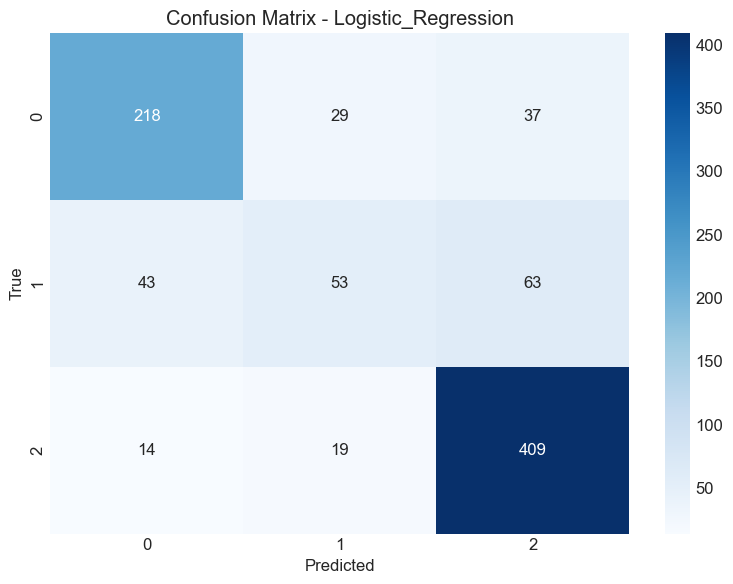

Baseline model saved.


In [25]:
print("Training Baseline Model: Logistic Regression")
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
cv_scores = cross_val_score(lr_pipeline, X_train, y_train, cv=cv, scoring='accuracy')
print(f"Cross-validation accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

lr_pipeline.fit(X_train, y_train)

print("\nEvaluating baseline model on test set:")
lr_metrics = evaluate_model(lr_pipeline, X_test, y_test, "Logistic_Regression")

joblib.dump(lr_pipeline, '../models/baseline_logistic_regression.joblib')
print("Baseline model saved.")

Create Random Forest pipeline
Define parameter grid for grid search
Set up grid search with cross-validation
Fit grid search
Print best parameters
Evaluate best model on test set
Save the best model
### 4.5 Gradient Boosting with Optuna Hyperparameter Tuning

Performing grid search for Random Forest...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}
Best cross-validation accuracy: 0.7742

Evaluating best Random Forest model on test set:

Classification Report for Random_Forest:
              precision    recall  f1-score   support

           0       0.80      0.74      0.77       284
           1       0.53      0.36      0.43       159
           2       0.79      0.93      0.85       442

    accuracy                           0.76       885
   macro avg       0.71      0.67      0.68       885
weighted avg       0.75      0.76      0.75       885



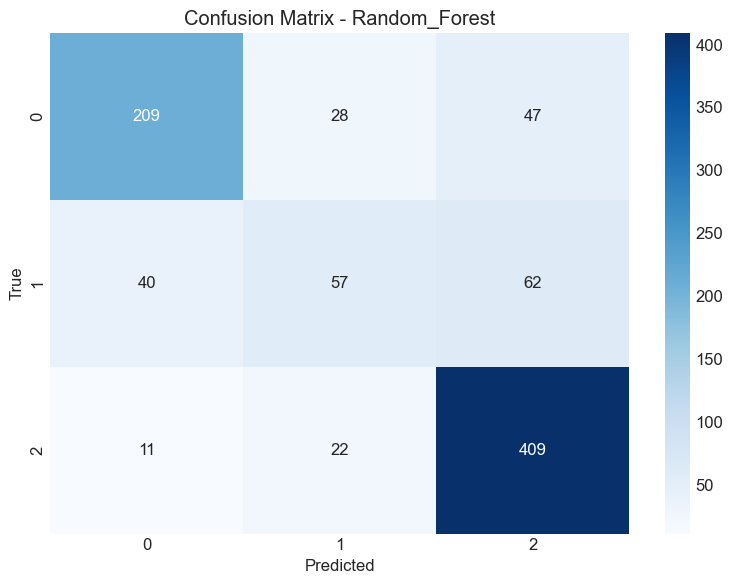

Tuned Random Forest model saved.


In [26]:
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=RANDOM_STATE))
])

param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(
    rf_pipeline, 
    param_grid, 
    cv=cv, 
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

print("Performing grid search for Random Forest...")
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

print("\nEvaluating best Random Forest model on test set:")
rf_metrics = evaluate_model(grid_search.best_estimator_, X_test, y_test, "Random_Forest")

joblib.dump(grid_search.best_estimator_, '../models/tuned_random_forest.joblib')
print("Tuned Random Forest model saved.")

Define an objective function for Optuna
Define hyperparameters to optimize
Create and preprocess the data
Create and train the model
Use cross-validation to evaluate
Return the mean accuracy

In [27]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'random_state': RANDOM_STATE
    }
    
    X_train_processed = preprocessor.fit_transform(X_train)
    
    model = GradientBoostingClassifier(**params)
    
    cv_scores = cross_val_score(
        model, X_train_processed, y_train, 
        cv=cv, scoring='accuracy', n_jobs=-1
    )
    
    return cv_scores.mean()

Create a study object and optimize the objective function
Print the best parameters
Create the final model with the best parameters
Train the model on the full training set
Evaluate on test set
Save the model
### 4.6 XGBoost Model

[I 2026-01-19 14:41:26,328] A new study created in memory with name: no-name-1e550626-2529-4d58-854a-4afbbcf6a886


Running Optuna optimization for Gradient Boosting...


[I 2026-01-19 14:41:45,731] Trial 0 finished with value: 0.7629264258144943 and parameters: {'n_estimators': 271, 'learning_rate': 0.27246658688722786, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 2, 'subsample': 0.6150731340318453}. Best is trial 0 with value: 0.7629264258144943.
[I 2026-01-19 14:41:59,313] Trial 1 finished with value: 0.7747912321498494 and parameters: {'n_estimators': 112, 'learning_rate': 0.06018992862535726, 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 2, 'subsample': 0.925268724158086}. Best is trial 1 with value: 0.7747912321498494.
[I 2026-01-19 14:42:10,467] Trial 2 finished with value: 0.7722492588241876 and parameters: {'n_estimators': 111, 'learning_rate': 0.09221534225634088, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 10, 'subsample': 0.7055689390602962}. Best is trial 1 with value: 0.7747912321498494.
[I 2026-01-19 14:42:18,251] Trial 3 finished with value: 0.7657472890146158 and parameters: {'n_estimators': 

Best parameters: {'n_estimators': 203, 'learning_rate': 0.12817293807879568, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 4, 'subsample': 0.9100610703174814}
Best accuracy: 0.7804

Evaluating best Gradient Boosting model on test set:

Classification Report for Gradient_Boosting:
              precision    recall  f1-score   support

           0       0.80      0.73      0.76       284
           1       0.52      0.45      0.48       159
           2       0.82      0.90      0.86       442

    accuracy                           0.77       885
   macro avg       0.71      0.69      0.70       885
weighted avg       0.76      0.77      0.76       885



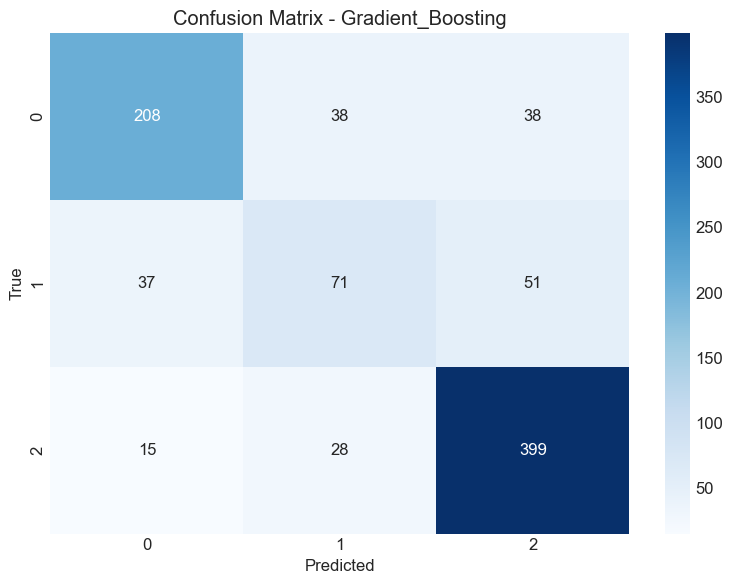

Tuned Gradient Boosting model saved.


In [30]:
print("Running Optuna optimization for Gradient Boosting...")
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)  # Adjust n_trials as needed

print(f"Best parameters: {study.best_params}")
print(f"Best accuracy: {study.best_value:.4f}")

gb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(**study.best_params))
])

gb_pipeline.fit(X_train, y_train)

print("\nEvaluating best Gradient Boosting model on test set:")
gb_metrics = evaluate_model(gb_pipeline, X_test, y_test, "Gradient_Boosting")

joblib.dump(gb_pipeline, '../models/tuned_gradient_boosting.joblib')
print("Tuned Gradient Boosting model saved.")

Create XGBoost pipeline
Define parameter grid for grid search
Set up grid search with cross-validation
Fit grid search
Print best parameters
Evaluate best model on test set
Save the best model
## 5. Model Comparison and Selection

Performing grid search for XGBoost...
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters: {'classifier__colsample_bytree': 1.0, 'classifier__learning_rate': 0.2, 'classifier__max_depth': 3, 'classifier__n_estimators': 100, 'classifier__subsample': 0.8}
Best cross-validation accuracy: 0.7838

Evaluating best XGBoost model on test set:

Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.81      0.73      0.77       284
           1       0.54      0.47      0.50       159
           2       0.81      0.90      0.86       442

    accuracy                           0.77       885
   macro avg       0.72      0.70      0.71       885
weighted avg       0.76      0.77      0.76       885



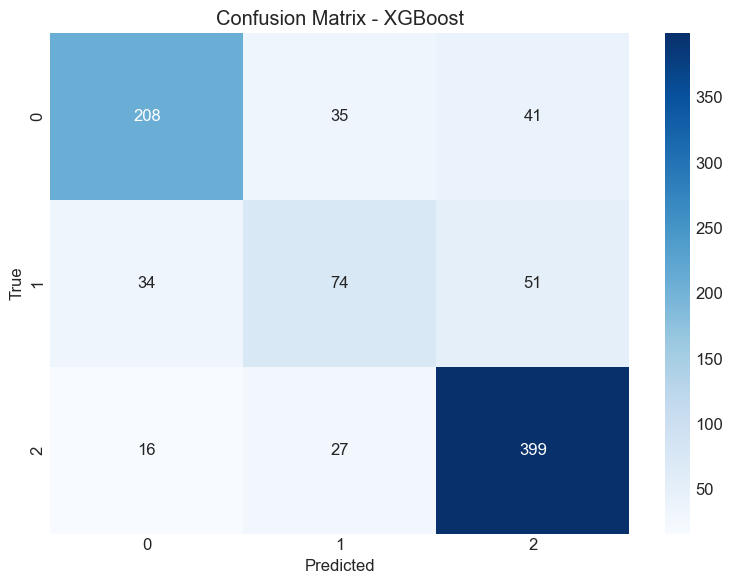

Tuned XGBoost model saved.


In [31]:
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(random_state=RANDOM_STATE))
])

param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 6, 9],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__subsample': [0.8, 1.0],
    'classifier__colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(
    xgb_pipeline, 
    param_grid, 
    cv=cv, 
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

print("Performing grid search for XGBoost...")
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

print("\nEvaluating best XGBoost model on test set:")
xgb_metrics = evaluate_model(grid_search.best_estimator_, X_test, y_test, "XGBoost")

joblib.dump(grid_search.best_estimator_, '../models/tuned_xgboost.joblib')
print("Tuned XGBoost model saved.")

Compare all models
Create comparison dataframe
Plot model comparison
## 6. Feature Importance Analysis

Model Performance Comparison:
                 Model  Accuracy  F1 Score (macro)
3              XGBoost  0.769492          0.708176
2    Gradient Boosting  0.766102          0.700833
1        Random Forest  0.762712          0.683012
0  Logistic Regression  0.768362          0.682601


<Figure size 1000x600 with 0 Axes>

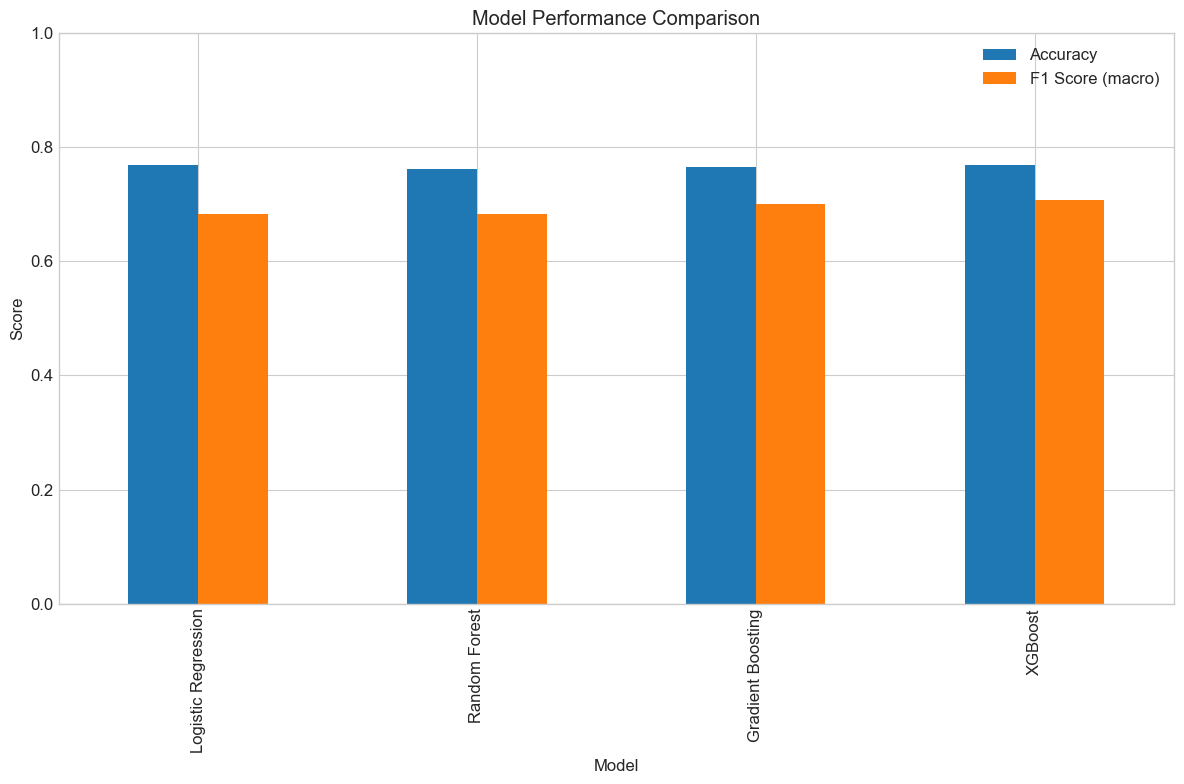

In [35]:
models = {
    'Logistic Regression': lr_metrics,
    'Random Forest': rf_metrics,
    'Gradient Boosting': gb_metrics,
    'XGBoost': xgb_metrics
}

comparison = pd.DataFrame({
    'Model': list(models.keys()),
    'Accuracy': [m['accuracy'] for m in models.values()],
    'F1 Score (macro)': [m['f1_score'] for m in models.values()]
})

print("Model Performance Comparison:")
print(comparison.sort_values('F1 Score (macro)', ascending=False))

plt.figure(figsize=(10, 6))
comparison.set_index('Model').plot(kind='bar')
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig('../models/model_comparison.png')
plt.show()

Get the best model
Extract feature names after preprocessing
Get numerical feature names
Get categorical feature names
Get feature importance from the model
Create a dataframe of feature importance
Plot feature importance
## 7. Model Deployment Preparation

Best model: XGBoost


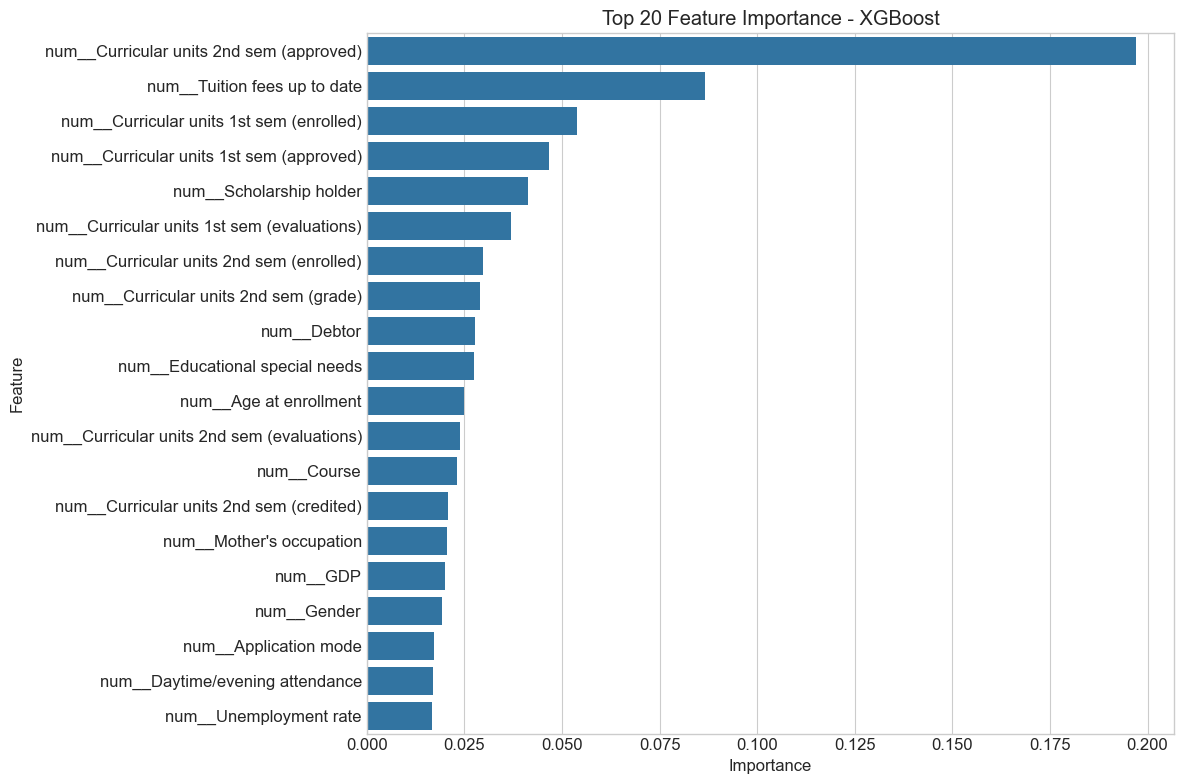

Top 20 most important features:
                                        Feature  Importance
30     num__Curricular units 2nd sem (approved)    0.196930
16                 num__Tuition fees up to date    0.086763
22     num__Curricular units 1st sem (enrolled)    0.053798
24     num__Curricular units 1st sem (approved)    0.046676
18                      num__Scholarship holder    0.041359
23  num__Curricular units 1st sem (evaluations)    0.036909
28     num__Curricular units 2nd sem (enrolled)    0.029771
31        num__Curricular units 2nd sem (grade)    0.028942
15                                  num__Debtor    0.027766
14               num__Educational special needs    0.027382
19                       num__Age at enrollment    0.024887
29  num__Curricular units 2nd sem (evaluations)    0.023812
3                                   num__Course    0.023220
27     num__Curricular units 2nd sem (credited)    0.020686
10                     num__Mother's occupation    0.020511
35      

In [42]:
best_model_name = comparison.sort_values('F1 Score (macro)', ascending=False).iloc[0]['Model']
if best_model_name == 'Logistic Regression':
    best_model = lr_pipeline
elif best_model_name == 'Random Forest':
    best_model = grid_search.best_estimator_  # From RF grid search
elif best_model_name == 'Gradient Boosting':
    best_model = gb_pipeline
else:  # XGBoost
    best_model = grid_search.best_estimator_  # From XGB grid search

print(f"Best model: {best_model_name}")

feature_names = []

# Use the fitted preprocessor from the best model pipeline
fitted_preprocessor = best_model.named_steps['preprocessor']

# Try to get feature names directly from the fitted preprocessor
try:
    feature_names = list(fitted_preprocessor.get_feature_names_out())
except:
    # If that fails, manually construct feature names
    feature_names = []
    
    # Add numerical feature names
    feature_names.extend(numerical_cols)
    
    # Add categorical feature names (manually construct one-hot encoded names)
    for col in categorical_cols:
        unique_values = df[col].unique()
        for val in unique_values:
            feature_names.append(f"{col}_{val}")

if hasattr(best_model.named_steps['classifier'], 'feature_importances_'):
    feature_importance = best_model.named_steps['classifier'].feature_importances_
    
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importance
    }).sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
    plt.title(f'Top 20 Feature Importance - {best_model_name}')
    plt.tight_layout()
    plt.savefig('../models/feature_importance.png')
    plt.show()
    
    print("Top 20 most important features:")
    print(importance_df.head(20))
else:
    print("Feature importance not available for this model type.")

Save the best model for deployment
Create a metadata file with model information
## 8. Conclusion and Next Steps

In [43]:
best_model_path = f'../models/best_model_{best_model_name.replace(" ", "_").lower()}.joblib'
joblib.dump(best_model, best_model_path)
print(f"Best model saved to {best_model_path}")

metadata = {
    'model_type': best_model_name,
    'accuracy': float(comparison[comparison['Model'] == best_model_name]['Accuracy']),
    'f1_score': float(comparison[comparison['Model'] == best_model_name]['F1 Score (macro)']),
    'features': {
        'numerical': numerical_cols,
        'categorical': categorical_cols
    },
    'preprocessing': {
        'numerical': 'median imputation + standard scaling',
        'categorical': 'most frequent imputation + one-hot encoding'
    },
    'target_classes': best_model.classes_.tolist()
}

import json
with open('../models/model_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=4)

print("Model metadata saved to ../models/model_metadata.json")

Best model saved to ../models/best_model_xgboost.joblib
Model metadata saved to ../models/model_metadata.json


In [44]:
print("Conclusion:")
print(f"1. Best performing model: {best_model_name}")
print(f"2. Accuracy: {comparison[comparison['Model'] == best_model_name]['Accuracy'].values[0]:.4f}")
print(f"3. F1 Score (macro): {comparison[comparison['Model'] == best_model_name]['F1 Score (macro)'].values[0]:.4f}")

print("\nNext Steps:")
print("1. Deploy the model as a web service")
print("2. Implement monitoring for model performance")
print("3. Develop a user interface for non-technical stakeholders")
print("4. Collect feedback and refine the model")
print("5. Explore additional data sources to improve predictions")

Conclusion:
1. Best performing model: XGBoost
2. Accuracy: 0.7695
3. F1 Score (macro): 0.7082

Next Steps:
1. Deploy the model as a web service
2. Implement monitoring for model performance
3. Develop a user interface for non-technical stakeholders
4. Collect feedback and refine the model
5. Explore additional data sources to improve predictions
